# Week 7 - Information Extraction


This week, we move from arbitrary textual classification to the use of computation and linguistic models to parse precise claims from documents. Rather than focusing on simply the *ideas* in a corpus, here we focus on understanding and extracting its precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases, like the Subject-Verb-Object (SVO) triples we extract here. While much of this can be done directly in the python package NLTK that we introduced in week 2, here we use NLTK bindings to the Stanford NLP group's open software, written in Java. Try typing a sentence into the online version [here]('http://nlp.stanford.edu:8080/corenlp/') to get a sense of its potential. It is superior in performance to NLTK's implementations, but takes time to run, and so for these exercises we will parse and extract information for a very small text corpus. Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:

In [2]:
#All these packages need to be installed from pip
#For NLP
import nltk
from nltk.tag import StanfordNERTagger
from nltk.tag import StanfordPOSTagger
from nltk.parse import stanford
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from nltk.draw.tree import TreeView
from nltk.tokenize import sent_tokenize

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

%matplotlib inline

If you want to use the [Stanford NLP group](http://nlp.stanford.edu/) programs with nltk on your own machine (you do *not* need to do this for this assignment), it will require a little bit of setup. We are basing these instructions on those provided by nltk, [here](https://github.com/nltk/nltk/wiki/Installing-Third-Party-Software#stanford-tagger-ner-tokenizer-and-parser), but with small changes to work with our notebooks. We also note that lower performance versions of many of the techniques demonstrated here are available natively within nltk (see the updated [nltk book](http://www.nltk.org/book/)).

1. Install [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html)
    + Make sure your `JAVAPATH` is setup if you're on windows
2. Download the following zip files from the Stanford NLP group, where DATE is the release date of the files, this will be the value of `stanfordVersion`
    + [`stanford-corenlp-full-2016-10-31.zip`](https://stanfordnlp.github.io/CoreNLP/)
    + [`stanford-postagger-full-DATE.zip`](http://nlp.stanford.edu/software/tagger.html#Download)
    + [`stanford-ner-DATE.zip`](http://nlp.stanford.edu/software/CRF-NER.html#Download)
    + [`stanford-parser-full-DATE.zip`](http://nlp.stanford.edu/software/lex-parser.html#Download)
3. Unzip the files and place the resulting directories in the same location, this will become `stanfordDir`
4. Lookup the version number used by the parser `stanford-parser-VERSION-models.jar` and set to to be `parserVersion`

In [3]:
#This is the date at the end of each of the zip files, e.g.
#the date in stanford-ner-2016-10-31.zip
stanfordVersion = '2016-10-31'

#This is the version numbers of the parser models, these
#are files in `stanford-parser-full-2016-10-31.zip`, e.g.
#stanford-parser-3.7.0-models.jar
parserVersion = '3.7.0'

#This is where the zip files were unzipped.Make sure to
#unzip into directories named after the zip files
#Don't just put all the files in `stanford-NLP`
stanfordDir = '/mnt/efs/resources/shared/stanford-NLP'

#Parser model, there are a few for english and a couple of other languages as well
modelName = 'englishPCFG.ser.gz'

We now will initialize all the tools

Setting up [NER tagger](http://www.nltk.org/api/nltk.tag.html?highlight=stanfordpostagger#nltk.tag.stanford.StanfordNERTagger)

In [4]:
nerClassifierPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'classifiers/english.all.3class.distsim.crf.ser.gz')

nerJarPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'stanford-ner.jar')

nerTagger = StanfordNERTagger(nerClassifierPath, nerJarPath)

Setting up [POS Tagger](http://www.nltk.org/api/nltk.tag.html?highlight=stanfordpostagger#nltk.tag.stanford.StanfordPOSTagger)

In [5]:
postClassifierPath = os.path.join(stanfordDir, 'stanford-postagger-full-{}'.format(stanfordVersion), 'models/english-bidirectional-distsim.tagger')

postJarPath = os.path.join(stanfordDir,'stanford-postagger-full-{}'.format(stanfordVersion), 'stanford-postagger.jar')

postTagger = StanfordPOSTagger(postClassifierPath, postJarPath)

Setting up [Parser](http://www.nltk.org/api/nltk.parse.html?highlight=stanfordparser#module-nltk.parse.stanford)

In [6]:
parserJarPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser.jar')

parserModelsPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser-{}-models.jar'.format(parserVersion))

modelPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), modelName)

#The model files are stored in the jar, we need to extract them for nltk to use
if not os.path.isfile(modelPath):
    with zipfile.ZipFile(parserModelsPath) as zf:
        with open(modelPath, 'wb') as f:
            f.write(zf.read('edu/stanford/nlp/models/lexparser/{}'.format(modelName)))

parser = stanford.StanfordParser(parserJarPath, parserModelsPath, modelPath)

depParser = stanford.StanfordDependencyParser(parserJarPath, parserModelsPath)

Open Information Extraction is a module packaged within the Stanford Core NLP package, but it is not yet supported by `nltk`. As a result, we will be defining our own function that runs the Stanford Core NLP java code right here. For other projects, it is often useful to use Java or other programs (in C, C++) within a python workflow, and this is an example. `openIE()` takes in a string or list of strings and then produces as output all the subject, verb, object (SVO) triples Stanford Corenlp can find, as a DataFrame.

In [7]:
#Watch out, this will very rarely raise an error since it trusts stanford-corenlp 
def openIE(target):
    if isinstance(target, list):
        target = '\n'.join(target)
    #setup the java targets
    coreDir = '{}/stanford-corenlp-full-{}'.format(stanfordDir, stanfordVersion)
    cp = '{0}/stanford-corenlp-{1}.jar:{0}/stanford-corenlp-{1}-models.jar:CoreNLP-to-HTML.xsl:slf4j-api.jar:slf4j-simple.jar'.format(coreDir, parserVersion)
    with tempfile.NamedTemporaryFile(mode = 'w', delete = False) as f:
        #Core nlp requires a files, so we will make a temp one to pass to it
        #This file should be deleted by the OS soon after it has been used
        f.write(target)
        f.seek(0)
        print("Starting OpenIE run")
        #If you know what these options do then you should mess with them on your own machine and not the shared server
        sp = subprocess.run(['java', '-mx2g', '-cp', cp, 'edu.stanford.nlp.naturalli.OpenIE', '-threads', '1', f.name], stdout = subprocess.PIPE, stderr = subprocess.PIPE)
        #Live stderr is non-trivial so this is the best we can do
        print(sp.stderr.decode('utf-8'))
        retSting = sp.stdout.decode('utf-8')
    #Making the DataFrame, again having to pass a fake file, yay POSIX I guess
    with io.StringIO(retSting) as f:
        df = pandas.read_csv(f, delimiter = '\t', names =['certainty', 'subject', 'verb', 'object'])
    return df

First, we will illustrate these tools on some *very* short examples:

In [8]:
guardian_automation = pandas.read_pickle('guardian_automation.pkl')
sample_automation = guardian_automation[:10]

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. The Stanford POS tagger uses the [Penn Treebank tag set]('http://repository.upenn.edu/cgi/viewcontent.cgi?article=1603&context=cis_reports') to POS tag words from input sentences. As discussed in the second assignment, this is a relatively precise tagset, which allows more informative tags, and also more opportunities to err :-).

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

In [9]:
sample_automation['tokenized_sents'] = sample_automation['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
sample_automation['POS_sents'] = sample_automation['tokenized_sents'].apply(lambda x: postTagger.tag_sents(x))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [10]:
sample_automation['POS_sents'][:20]

0    [[(There, EX), (are, VBP), (some, DT), (hopefu...
1    [[(Regional, NNP), (locations, NNS), (are, VBP...
2    [[(Trains, NNS), (with, IN), (a, DT), (guard, ...
3    [[(Women, NNP), (will, MD), (again, RB), (lose...
4    [[(We, PRP), (need, VBP), (to, TO), (face, VB)...
5    [[(Automation, NN), (is, VBZ), (blocking, VBG)...
6    [[(Editor-in-chief, NN), (Pete, NNP), (Clifton...
7    [[(Join, VB), (experts, NNS), (online, JJ), (o...
8    [[(Katie, NNP), (Allen, NNP), (poses, VBZ), (t...
9    [[(Automotive, NNP), (giant, NN), (looks, VBZ)...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [11]:
countTarget = 'NN'
targetCounts = {}
for entry in sample_automation['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:10]

[('%', 56),
 ('automation', 44),
 ('work', 39),
 ('manufacturing', 35),
 ('technology', 32),
 ('job', 27),
 ('employment', 26),
 ('–', 26),
 ('output', 22),
 ('industry', 19)]

What about the number of top verbs (`VB`)?

In [12]:
countTarget = 'VB'
targetCounts = {}
for entry in sample_automation['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:10]

[('be', 93),
 ('have', 13),
 ('make', 10),
 ('take', 9),
 ('create', 9),
 ('do', 8),
 ('need', 7),
 ('replace', 6),
 ('change', 6),
 ('see', 6)]

What about the number of top verbs (JJ)?

In [13]:
countTarget = 'JJ'
targetCounts = {}
for entry in sample_automation['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:10]

[('economic', 19),
 ('new', 19),
 ('such', 18),
 ('human', 15),
 ('same', 14),
 ('significant', 13),
 ('low', 11),
 ('many', 11),
 ('other', 11),
 ('current', 10)]

What about the adjectives that modify the word, "job"?

In [14]:
NTarget = 'JJ'
Word = 'job'
NResults = set()
for entry in sample_automation['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'further', '4m', 'inevitable', 'concomitant', 'well-paid'}


## *My Memo*
As expected, the most frequent NN-tagged word is 'automation'. This is because the corpus consists of the articles I collected using 'automation' as the search term. Other common nouns include: work, manufacturing, technology, job and employment. This suggests that 'automation' is a topic closely related to economy as much as to technology. The common verbs suggest that the articles talk much about changes (create, replace, change). The common adjectives are more difficult to understand although there is a sense of undertainty about the topic ('same' and 'new' are both frequent words). Finally, the noun 'automation' is most often modified by 'robotic' and 'workplace': it is indeed a subject about economy and job.

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. Included with Stanford NER are a 4 class model trained on the CoNLL 2003 eng.train, a 7 class model trained on the MUC 6 and MUC 7 training data sets, and a 3 class model trained on both data sets plus some additional data (including ACE 2002 and limited data in-house) on the intersection of those class sets. 

**3 class**:	Location, Person, Organization

**4 class**:	Location, Person, Organization, Misc

**7 class**:	Location, Person, Organization, Money, Percent, Date, Time

These models each use distributional similarity features, which provide some performance gain at the cost of increasing their size and runtime. Also available are the same models missing those features.

(We note that the training data for the 3 class model does not include any material from the CoNLL eng.testa or eng.testb data sets, nor any of the MUC 6 or 7 test or devtest datasets, nor Alan Ritter's Twitter NER data, so all of these would be valid tests of its performance.)

We can also run NER over our entire corpus:

In [15]:
sample_automation['classified_sents'] = sample_automation['tokenized_sents'].apply(lambda x: nerTagger.tag_sents(x))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Find the most common entities (which are, of course, boring):

In [16]:
entityCounts = {}
for entry in sample_automation['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('the', 555),
 (',', 528),
 ('.', 447),
 ('of', 371),
 ('to', 348),
 ('and', 313),
 ('in', 210),
 ('a', 207),
 ('is', 179),
 ('that', 154)]

Or those occurring only twice:

In [17]:
[x[0] for x in sortedEntities if x[1] == 2]

['training',
 'parents',
 'reverse',
 'realities',
 'discovered',
 'contributing',
 'nurses',
 'Editors',
 'solve',
 'raise',
 'accurate',
 'problems',
 'central',
 'read',
 'exciting',
 'today',
 'identified',
 'Pete',
 'anywhere',
 'power',
 'order',
 'Not',
 'UK’s',
 'mostly',
 'Motors',
 'caregivers',
 'diminishing',
 'becoming',
 'begin',
 'Science',
 'Amazon',
 'won',
 'held',
 'machinery',
 'form',
 'Cruise’s',
 'female-dominated',
 'write-ups',
 'immune',
 'boom',
 'first',
 'free-trade',
 'Francisco',
 'GDP',
 'moves',
 'true',
 'soon',
 'participating',
 'court',
 'computer',
 'His',
 'Bank',
 'service',
 'challenge',
 'judges',
 'shown',
 'Southern',
 'Encouragingly',
 'meet',
 'Asia',
 'families',
 '[',
 '“It',
 'ethics',
 'taxes',
 'London',
 'product',
 'again',
 'May',
 'progress',
 'innovate',
 'demonstrates',
 '2',
 'starts',
 'Electric',
 'systems',
 'according',
 'speciality',
 'Machines',
 'professions',
 'expensive',
 'breadth',
 'Valley',
 'carbon',
 'cheap',
 'bu

List the most common "non-objects".

In [18]:
nonObjCounts = {}
for entry in sample_automation['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Australia', 23),
 ('USA', 18),
 ('US', 10),
 ('of', 9),
 ('UK', 9),
 ('GFC', 9),
 ('University', 7),
 ('Watson', 6),
 ('Martin', 6),
 ('Hegerty', 5)]

What about the Organizations?

In [19]:
OrgCounts = {}
for entry in sample_automation['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'ORGANIZATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('GFC', 9),
 ('of', 8),
 ('University', 6),
 ('WEF', 4),
 ('Press', 4),
 ('Technology', 3),
 ('Apple', 3),
 ('Bank', 2),
 ('for', 2),
 ('Queensland', 2)]

Persons?

In [20]:
OrgCounts = {}
for entry in sample_automation['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'PERSON':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Watson', 6),
 ('Martin', 6),
 ('Hegerty', 5),
 ('Clifton', 3),
 ('George', 3),
 ('Altman', 3),
 ('Rodrik', 3),
 ('Baxter', 2),
 ('Deloitte', 2),
 ('Munro', 2)]

Locations!

In [21]:
OrgCounts = {}
for entry in sample_automation['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != 'LOCATION':
                continue
            elif ent in OrgCounts:
                OrgCounts[ent] += 1
            else:
                OrgCounts[ent] = 1
sortedOrgs = sorted(OrgCounts.items(), key = lambda x: x[1], reverse = True)
sortedOrgs[:10]

[('Australia', 22),
 ('USA', 18),
 ('US', 10),
 ('UK', 9),
 ('India', 4),
 ('South', 3),
 ('China', 2),
 ('Francisco', 2),
 ('San', 2),
 ('Queensland', 2)]

In [22]:
machine_coded = sample_automation['classified_sents'][1][:10]

In [23]:
hand_coded = [[('Regional', 'O'),
  ('locations', 'O'),
  ('are', 'O'),
  ('seeing', 'O'),
  ('the', 'O'),
  ('first', 'O'),
  ('effects', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('fourth', 'O'),
  ('industrial', 'O'),
  ('revolution', 'O'),
  ('.', 'O')],
 [('How', 'O'),
  ('these', 'O'),
  ('businesses', 'O'),
  ('respond', 'O'),
  ('will', 'O'),
  ('be', 'O'),
  ('a', 'O'),
  ('lesson', 'O'),
  ('for', 'O'),
  ('everyone', 'O'),
  ('When', 'O'),
  ('Andrew', 'PERSON'),
  ('Hegerty', 'PERSON'),
  ('started', 'O'),
  ('investigating', 'O'),
  ('how', 'O'),
  ('automation', 'O'),
  ('could', 'O'),
  ('improve', 'O'),
  ('his', 'O'),
  ('engineering', 'O'),
  ('business', 'O'),
  ('in', 'O'),
  ('Mackay', 'LOCATION'),
  ('seven', 'O'),
  ('months', 'O'),
  ('ago', 'O'),
  (',', 'O'),
  ('a', 'O'),
  ('few', 'O'),
  ('eyebrows', 'O'),
  ('were', 'O'),
  ('raised', 'O'),
  ('.', 'O')],
 [('Various', 'O'),
  ('economists', 'O'),
  ('predict', 'O'),
  ('automation', 'O'),
  ('is', 'O'),
  ('on', 'O'),
  ('the', 'O'),
  ('cusp', 'O'),
  ('of', 'O'),
  ('destroying', 'O'),
  ('millions', 'O'),
  ('of', 'O'),
  ('Australian', 'O'),
  ('jobs', 'O'),
  ('and', 'O'),
  ('Hegerty’s', 'O'),
  ('was', 'O'),
  ('a', 'O'),
  ('labour-intensive', 'O'),
  ('workplace', 'O'),
  ('.', 'O')],
 [('For', 'O'),
  ('Hegerty', 'PERSON'),
  (',', 'O'),
  ('fear', 'O'),
  ('has', 'O'),
  ('been', 'O'),
  ('replaced', 'O'),
  ('by', 'O'),
  ('a', 'O'),
  ('belief', 'O'),
  ('that', 'O'),
  ('automation', 'O'),
  ('not', 'O'),
  ('only', 'O'),
  ('holds', 'O'),
  ('the', 'O'),
  ('key', 'O'),
  ('to', 'O'),
  ('long-term', 'O'),
  ('survival', 'O'),
  ('but', 'O'),
  ('it', 'O'),
  ('can', 'O'),
  ('create', 'O'),
  ('better', 'O'),
  ('jobs', 'O'),
  ('than', 'O'),
  ('those', 'O'),
  ('replaced', 'O'),
  ('.', 'O')],
 [('More', 'O'),
  ('to', 'O'),
  ('the', 'O'),
  ('point', 'O'),
  (',', 'O'),
  ('he', 'O'),
  ('says', 'O'),
  ('there', 'O'),
  ('is', 'O'),
  ('simply', 'O'),
  ('no', 'O'),
  ('choice', 'O'),
  ('–', 'O'),
  ('businesses', 'O'),
  ('like', 'O'),
  ('his', 'O'),
  ('can', 'O'),
  ('embrace', 'O'),
  ('automation', 'O'),
  ('or', 'O'),
  ('disappear', 'O'),
  ('.', 'O')],
 [('“I', 'O'),
  ('believe', 'O'),
  ('that', 'O'),
  ('automation', 'O'),
  ('will', 'O'),
  ('be', 'O'),
  ('the', 'O'),
  ('cornerstone', 'O'),
  ('of', 'O'),
  ('our', 'O'),
  ('business', 'O'),
  ('within', 'O'),
  ('the', 'O'),
  ('next', 'O'),
  ('five', 'O'),
  ('years', 'O'),
  (',', 'O'),
  ('”', 'O'),
  ('he', 'O'),
  ('says', 'O'),
  ('.', 'O')],
 [('“Manual', 'O'),
  ('fabrication', 'O'),
  ('will', 'O'),
  ('become', 'O'),
  ('the', 'O'),
  ('exception', 'O'),
  ('rather', 'O'),
  ('than', 'O'),
  ('the', 'O'),
  ('rule.”', 'O'),
  ('Hegerty’s', 'ORGANIZATION'),
  ('company', 'ORGANIZATION'),
  (',', 'O'),
  ('the', 'O'),
  ('Mackay-based', 'ORGANIZATION'),
  ('Team', 'ORGANIZATION'),
  ('Group', 'ORGANIZATION'),
  ('(', 'O'),
  ('Australia', 'LOCATION'),
  (')', 'O'),
  (',', 'O'),
  ('provides', 'O'),
  ('engineering', 'O'),
  (',', 'O'),
  ('fabrication', 'O'),
  (',', 'O'),
  ('maintenance', 'O'),
  ('and', 'O'),
  ('other', 'O'),
  ('services', 'O'),
  ('to', 'O'),
  ('the', 'O'),
  ('mining', 'O'),
  ('industry', 'O'),
  (',', 'O'),
  ('mainly', 'O'),
  ('in', 'O'),
  ('nearby', 'O'),
  ('central', 'LOCATION'),
  ('Queensland', 'LOCATION'),
  (',', 'O'),
  ('but', 'O'),
  ('now', 'O'),
  ('also', 'O'),
  ('to', 'O'),
  ('some', 'O'),
  ('overseas', 'O'),
  ('clients', 'O'),
  ('.', 'O')],
 [('North', 'LOCATION'),
  ('and', 'LOCATION'),
  ('central', 'LOCATION'),
  ('Queensland', 'LOCATION'),
  ('are', 'O'),
  ('exactly', 'O'),
  ('the', 'O'),
  ('sort', 'O'),
  ('of', 'O'),
  ('locations', 'O'),
  ('economists', 'O'),
  ('say', 'O'),
  ('could', 'O'),
  ('be', 'O'),
  ('savaged', 'O'),
  ('by', 'O'),
  ('workplace', 'O'),
  ('automation', 'O'),
  ('if', 'O'),
  ('the', 'O'),
  ('right', 'O'),
  ('policies', 'O'),
  ('are', 'O'),
  ('not', 'O'),
  ('put', 'O'),
  ('in', 'O'),
  ('place', 'O'),
  ('to', 'O'),
  ('foster', 'O'),
  ('innovation', 'O'),
  ('and', 'O'),
  ('skills', 'O'),
  ('for', 'O'),
  ('a', 'O'),
  ('new', 'O'),
  ('marketplace', 'O'),
  ('.', 'O')],
 [('Examples', 'O'),
  ('of', 'O'),
  ('automation', 'O'),
  ('are', 'O'),
  ('popping', 'O'),
  ('up', 'O'),
  ('regularly', 'O'),
  ('in', 'O'),
  ('regional', 'LOCATION'),
  ('Australia', 'LOCATION'),
  ('.', 'O')],
 [('Driverless', 'O'),
  ('trucks', 'O'),
  ('have', 'O'),
  ('been', 'O'),
  ('operating', 'O'),
  ('above', 'O'),
  ('ground', 'O'),
  ('for', 'O'),
  ('some', 'O'),
  ('time', 'O'),
  (',', 'O'),
  ('particularly', 'O'),
  ('in', 'O'),
  ('Western', 'LOCATION'),
  ('Australia', 'LOCATION'),
  (',', 'O'),
  ('and', 'O'),
  ('now', 'O'),
  ('Queensland', 'ORGANIZATION'),
  ('University', 'ORGANIZATION'),
  ('of', 'ORGANIZATION'),
  ('Technology', 'ORGANIZATION'),
  ('is', 'O'),
  ('working', 'O'),
  ('with', 'O'),
  ('Caterpillar', 'ORGANIZATION'),
  ('to', 'O'),
  ('develop', 'O'),
  ('driverless', 'O'),
  ('trucks', 'O'),
  ('that', 'O'),
  ('can', 'O'),
  ('operate', 'O'),
  ('in', 'O'),
  ('underground', 'O'),
  ('mines', 'O'),
  ('.', 'O')]]

In [24]:
# compare the machine-generated tags with human-coded tags
words = []
tags_machine = []
for sent in machine_coded:
    for word, tag in sent:
        words.append(word)
        tags_machine.append(tag)

tags_human = []
for sent in hand_coded:
    for word, tag in sent:
        tags_human.append(tag)

compareDF = pandas.DataFrame({'words':words,
                  'tags_machine': tags_machine,
                  'tags_human': tags_human})

compareDF

,tags_human,tags_machine,words
0,O,O,Regional
1,O,O,locations
2,O,O,are
3,O,O,seeing
4,O,O,the
5,O,O,first
6,O,O,effects
7,O,O,of
8,O,O,the
9,O,O,fourth


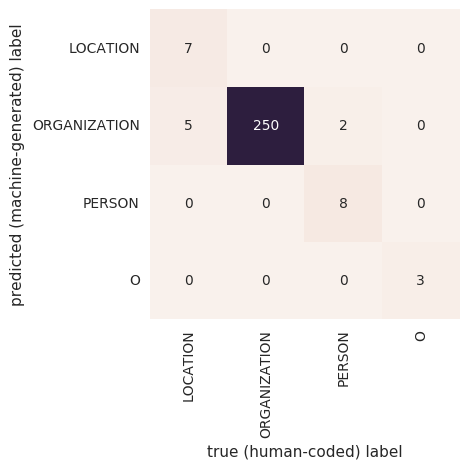

In [25]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(compareDF['tags_human'], compareDF['tags_machine'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
               xticklabels=list(set(compareDF['tags_human'])), yticklabels=list(set(compareDF['tags_machine'])))
plt.xlabel('true (human-coded) label')
plt.ylabel('predicted (machine-generated) label');

In [26]:
import sklearn
print('precision:', sklearn.metrics.precision_score(compareDF['tags_human'], compareDF['tags_machine'], average = 'weighted')) #precision
print('recall:', sklearn.metrics.recall_score(compareDF['tags_human'], compareDF['tags_machine'], average = 'weighted')) #recall
print('F1 measure:', sklearn.metrics.f1_score(compareDF['tags_human'], compareDF['tags_machine'], average = 'weighted')) #F-1 

precision: 0.975238769013
recall: 0.974545454545
F1 measure: 0.971924791358


## *My Memo*


I performed NER on the first ten articles of my corpus. Most organizations are companies and most names are English-sounding names. Also, most locations are English-speaking countries. From these, it is possible to conclude that these articles are mostly concerned with companies and people in English speaking countires.

I also tried a quick comparison between the Stanford NER tags and my own NER tags using only 10 sentences from one of the articles. Standford NER tagger and I agreed on most of the tags. The precision, recall and F1 measure scores looks pretty good. However, the heatmap shows that  this may be because there are so many 'non-objects' in the text used for NER tagging. Given that, I and Standford tagger disagreed quite much with Location words.

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

# Parsing

Here we will introduce the Stanford Parser by feeding it tokenized text from our initial example sentences. The parser is a dependency parser, but this initial program outputs a simple, self-explanatory phrase-structure representation.

In [125]:
parses = list(parser.parse_sents(sample_automation['tokenized_sents'][1])) #Converting the iterator to a list so we can call by index. They are still 
firstSentParseTree = list(parses[0]) #iterators so be careful about re-running code, without re-running this block
fourthSentParseTree = list(parses[3])
print(firstSentParseTree)
print(fourthSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('NNP', ['Regional']), Tree('NNS', ['locations'])]), Tree('VP', [Tree('VBP', ['are']), Tree('VP', [Tree('VBG', ['seeing']), Tree('NP', [Tree('NP', [Tree('DT', ['the']), Tree('JJ', ['first']), Tree('NNS', ['effects'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('DT', ['the']), Tree('JJ', ['fourth']), Tree('JJ', ['industrial']), Tree('NN', ['revolution'])])])])])]), Tree('.', ['.'])])])]
[Tree('ROOT', [Tree('S', [Tree('PP', [Tree('IN', ['For']), Tree('NP', [Tree('NNP', ['Hegerty'])])]), Tree(',', [',']), Tree('NP', [Tree('NN', ['fear'])]), Tree('VP', [Tree('VBZ', ['has']), Tree('VP', [Tree('VBN', ['been']), Tree('VP', [Tree('VBN', ['replaced']), Tree('PP', [Tree('IN', ['by']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['belief'])])]), Tree('SBAR', [Tree('IN', ['that']), Tree('S', [Tree('S', [Tree('NP', [Tree('NN', ['automation'])]), Tree('CONJP', [Tree('RB', ['not']), Tree('JJ', ['only'])]), Tree('VP', [Tree('VBZ', ['holds']), Tree('NP', 

Trees are a common data structure and there are a large number of things to do with them. What we are intetered in is the relationship between different types of speech

In [71]:
def treeRelation(parsetree, relationType, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retList = []
        for subT in parsetree.subtrees():
            if subT.label() == relationType:
                if set(targets) & set(subT.leaves()) == set(targets):
                    retList.append([(subT.label(), ' '.join(subT.leaves()))])
    return retList

In [65]:
def treeSubRelation(parsetree, relationTypeScope, relationTypeTarget, *targets):
    if isinstance(parsetree, list):
        parsetree = parsetree[0]
    if set(targets) & set(parsetree.leaves()) != set(targets):
        return []
    else:
        retSet = set()
        for subT in parsetree.subtrees():
            if set(targets) & set(subT.leaves()) == set(targets):
                if subT.label() == relationTypeScope:
                    for subsub in subT.subtrees():
                        if subsub.label()==relationTypeTarget:
                            retSet.add(' '.join(subsub.leaves()))
    return retSet

In [72]:
# parse tree of the first sentence
firstSentParseTree[0].pretty_print()

                                              ROOT                                          
                                               |                                             
                                               S                                            
           ____________________________________|__________________________________________   
          |                  VP                                                           | 
          |              ____|__________                                                  |  
          |             |               VP                                                | 
          |             |     __________|____________                                     |  
          |             |    |                       NP                                   | 
          |             |    |           ____________|___                                 |  
          |             |    |          |                PP      

Or another, more complex sentence

In [126]:
fourthSentParseTree[0].pretty_print()

                                                                                              ROOT                                                                                                      
                                                                                               |                                                                                                         
                                                                                               S                                                                                                        
      _________________________________________________________________________________________|______________________________________________________________________________________________________   
     |           |   |        VP                                                                                                                                                                  

In [96]:
treeSubRelation(firstSentParseTree, 'NP', 'JJ') # adjectives motifying nouns in noun phrases

{'first', 'fourth', 'industrial'}

In [90]:
treeSubRelation(firstSentParseTree, 'NP', 'NP') # noun phrases in noun phrases

{'Regional locations',
 'the first effects',
 'the first effects of the fourth industrial revolution',
 'the fourth industrial revolution'}

In [91]:
treeSubRelation(firstSentParseTree, 'VP', 'NP') # noun phrases in verb phrases

{'the first effects',
 'the first effects of the fourth industrial revolution',
 'the fourth industrial revolution'}

In [92]:
treeSubRelation(firstSentParseTree, 'VP', 'VP') # verb phrases in verb phrases

{'are seeing the first effects of the fourth industrial revolution',
 'seeing the first effects of the fourth industrial revolution'}

In [93]:
treeSubRelation(firstSentParseTree, 'NP', 'NNS') # plural nouns in noun phrases

{'effects', 'locations'}

In [136]:
treeSubRelation(fourthSentParseTree, 'S', 'VP', 'automation') # verb phrases related to the word 'automation'

{'been replaced by a belief that automation not only holds the key to long-term survival but it can create better jobs than those replaced',
 'can create better jobs than those replaced',
 'create better jobs than those replaced',
 'has been replaced by a belief that automation not only holds the key to long-term survival but it can create better jobs than those replaced',
 'holds the key to long-term survival',
 'replaced',
 'replaced by a belief that automation not only holds the key to long-term survival but it can create better jobs than those replaced'}

In [137]:
treeSubRelation(fourthSentParseTree, 'S', 'VB', 'automation') # verb phrases related to the word 'automation'

{'create'}

In [138]:
treeSubRelation(fourthSentParseTree, 'S', 'VBZ', 'automation') # verb phrases related to the word 'automation'

{'has', 'holds'}

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

In [128]:
depParses = list(depParser.parse_sents(sample_automation['tokenized_sents'][1])) #Converting the iterator to a list so we can call by index. They are still 
firstSentDepParseTree = list(depParses[0])[0] #iterators so be careful about re-running code, without re-running this block
fourthSentDepParseTree = list(depParses[3])[0]
print(firstSentDepParseTree)
print(fourthSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x7f7453413bf8>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [4]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'NNP',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 2,
                 'lemma': '_',
                 'rel': 'compound',
                 'tag': 'NNP',
                 'word': 'Regional'},
             2: {'address': 2,
                 'ctag': 'NNS',
                 'deps': defaultdict(<class 'list'>, {'compound': [1]}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'nsubj',
                 'ta

This is a graph and we can convert it to a dot file and use that to visulize it. Try traversing the tree and extracting elements that are nearby one another.

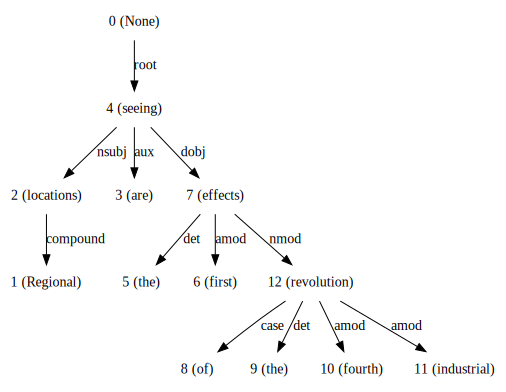

In [44]:
firstSentGraph = graphviz.Source(firstSentDepParseTree.to_dot())
firstSentGraph

Or another, more complex sentence 

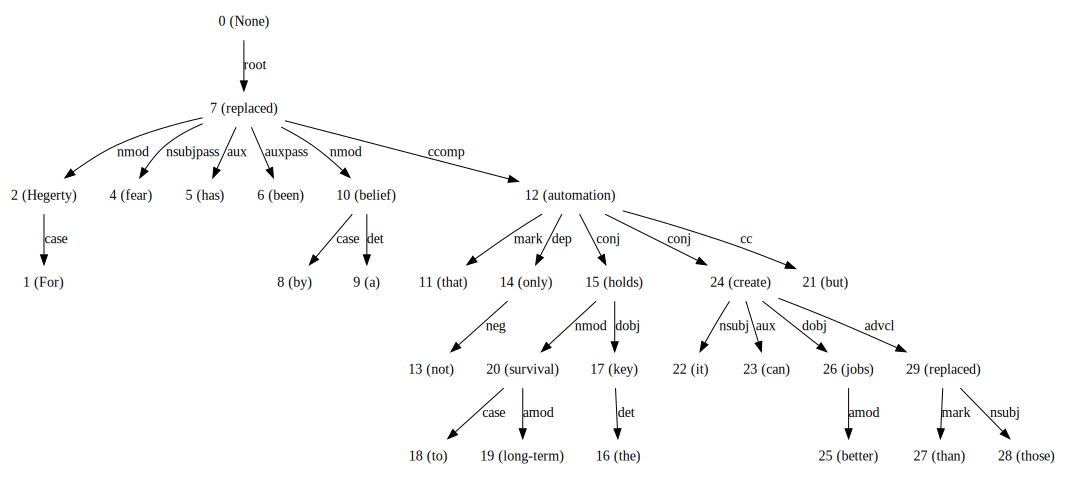

In [129]:
fourthSentGraph = graphviz.Source(fourthSentDepParseTree.to_dot())
fourthSentGraph

## *My Memo*

I have parsed one article and created parse tree and dependency tree for two of the sentences in the article. For the first, simpler sentence, the largest pares depth is eight. For the second, more complex sentence, the number seems higher. The length and complexity of the parsing structure makes it diffecult to identify the greatest number of parse depth for the sentence. The parsing of the fourth sentence shows that 'automation' is an important factor that creates new jobs and is crucial to the long-term survival.

# Information extraction

Information extraction approaches typically (as here, with Stanford's Open IE engine) ride atop the dependency parse of a sentence. They are a pre-coded example of the type analyzed in the prior. 

## <span style="color:red">*Your Turn*</span>

<span style="color:red">In the cells immediately following, perform open information extraction on a modest subset of texts relevant to your final project. Analyze the relative attachment of several subjects relative to verbs and objects and visa versa? Describe how you would select among these statements to create a database of high-value statements for your project and do it.

And we can also look for subject, object, target triples in one of the reddit stories.

In [ ]:
ieDF = openIE(sample_automation['text'][1])

Starting OpenIE run


In [ ]:
ieDF

In [ ]:
len(sample_automation['tokenized_sents'][1])

In [ ]:
sum([len(s) for s in sample_automation['tokenized_sents'][1]])

Lets find at the most common subject in this story.

In [ ]:
ieDF['subject'].value_counts()

I is followed by various male pronouns and compound nouns (e.g., "old man"). 'I' occures most often with the following verbs:

In [ ]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

and the following objects

In [ ]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

## *My Memo*

Unfortunately, I was not able to run ieDF() either on the cloud or on my local Windows machine...